## Implementing [Delaunay triangulation](https://en.wikipedia.org/wiki/Delaunay_triangulation?useskin=vector) for convertion raster image to vector image.

In [1]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from matplotlib.collections import PolyCollection
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image
import numpy as np

In [2]:
# Load the image
img = Image.open('data/input_image.jpeg')
img = img.convert('RGB')
img_array = np.array(img)

In [3]:
# Convert to grayscale
gray_img = np.mean(img_array, axis=2)

# Compute gradients
grad_x = ndimage.sobel(gray_img, axis=0, mode='constant')
grad_y = ndimage.sobel(gray_img, axis=1, mode='constant')
grad_mag = np.hypot(grad_x, grad_y)

# Threshold the gradient magnitude to get edge points
threshold = np.percentile(grad_mag, 90)
edges = grad_mag > threshold

# Extract coordinates of edge pixels
y_coords, x_coords = np.nonzero(edges)
points = np.column_stack((x_coords, y_coords))

# Perform Delaunay triangulation
tri = Delaunay(points)
triangles = tri.simplices

# Get colors for each triangle
colors = []
for triangle in triangles:
    vertices = points[triangle]
    centroid = np.mean(vertices, axis=0)
    x, y = int(centroid[0]), int(centroid[1])
    x = np.clip(x, 0, img_array.shape[1] - 1)
    y = np.clip(y, 0, img_array.shape[0] - 1)
    color = img_array[y, x, :]
    colors.append(color / 255.0)  # Normalize color values

# Build the list of triangle vertex coordinates
verts = points[triangles]

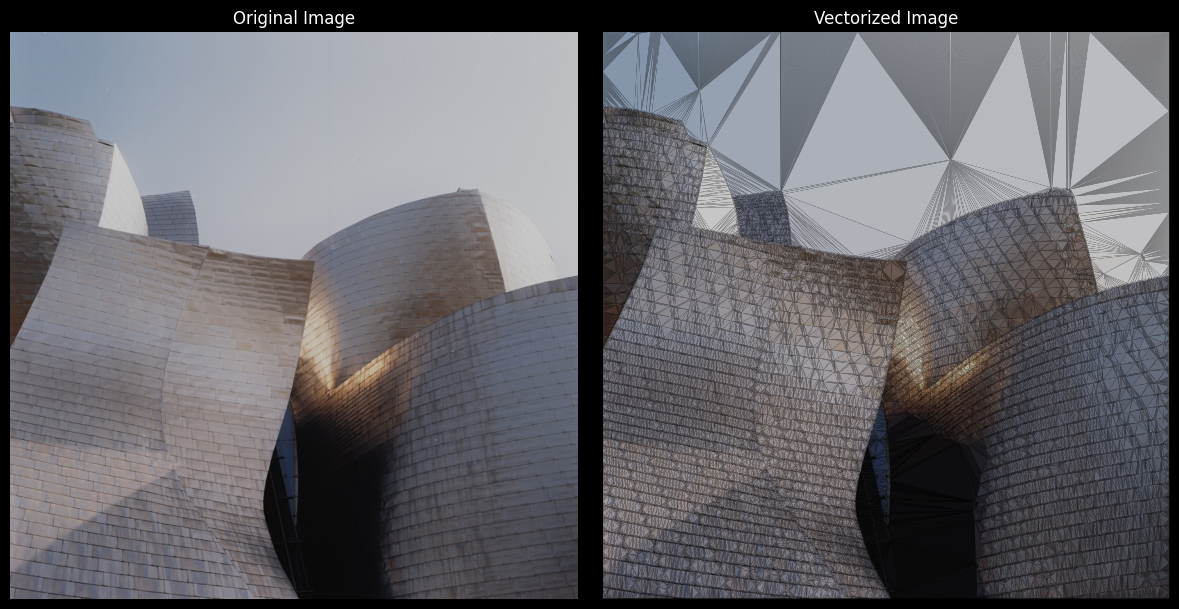

In [4]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Plot vectorized image
plt.subplot(1, 2, 2)
ax = plt.gca()
ax.set_xlim(0, img_array.shape[1])
ax.set_ylim(img_array.shape[0], 0)
ax.set_aspect('equal')
ax.axis('off')

# Create a PolyCollection for the triangles
pc = PolyCollection(verts, facecolors=colors, edgecolors='none')
ax.add_collection(pc)

plt.title('Vectorized Image')
plt.tight_layout()
plt.show()

Vector image saved as 'vectorized_image.svg'


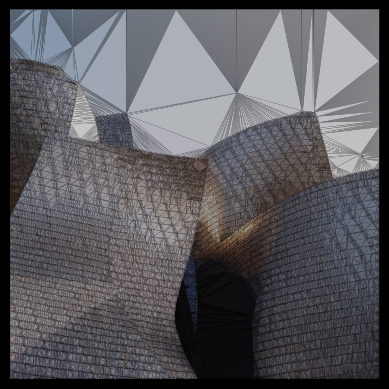

In [5]:
# Save the vector image to an SVG file
fig, ax = plt.subplots()
ax.set_xlim(0, img_array.shape[1])
ax.set_ylim(img_array.shape[0], 0)
ax.set_aspect('equal')
ax.axis('off')
pc = PolyCollection(verts, facecolors=colors, edgecolors='none')
ax.add_collection(pc)
plt.savefig('data/vectorized_image.svg', format='svg', bbox_inches='tight')
print("Vector image saved as 'vectorized_image.svg'")

In [6]:
# Reduce the number of triangles and colors

# Randomly sample points to further reduce number of triangles
sample_fraction = 0.1  # Keep 10% of the points
sample_size = int(sample_fraction * len(points))
indices = np.random.choice(len(points), sample_size, replace=False)
points = points[indices]

# Perform clustering to reduce points
n_clusters = 2500  # Adjust this number based on desired detail
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(points)
points = kmeans.cluster_centers_

# Perform Delaunay triangulation
tri = Delaunay(points)
triangles = tri.simplices

# Quantize colors to reduce color information
n_colors = 16  # Adjust this number based on desired color detail
reshaped_img = img_array.reshape(-1, 3)
kmeans_colors = MiniBatchKMeans(n_clusters=n_colors, random_state=0).fit(reshaped_img)
labels = kmeans_colors.predict(reshaped_img)
img_array = kmeans_colors.cluster_centers_.astype('uint8')[labels]
img_array = img_array.reshape(img_array.shape[0] // img.width, img.width, 3)

# Get colors for each triangle
colors = []
for triangle in triangles:
    vertices = points[triangle]
    centroid = np.mean(vertices, axis=0)
    x, y = int(centroid[0]), int(centroid[1])
    x = np.clip(x, 0, img_array.shape[1] - 1)
    y = np.clip(y, 0, img_array.shape[0] - 1)
    color = img_array[y, x, :]
    colors.append(color / 255.0)  # Normalize color values

# Build the list of triangle vertex coordinates
verts = points[triangles]

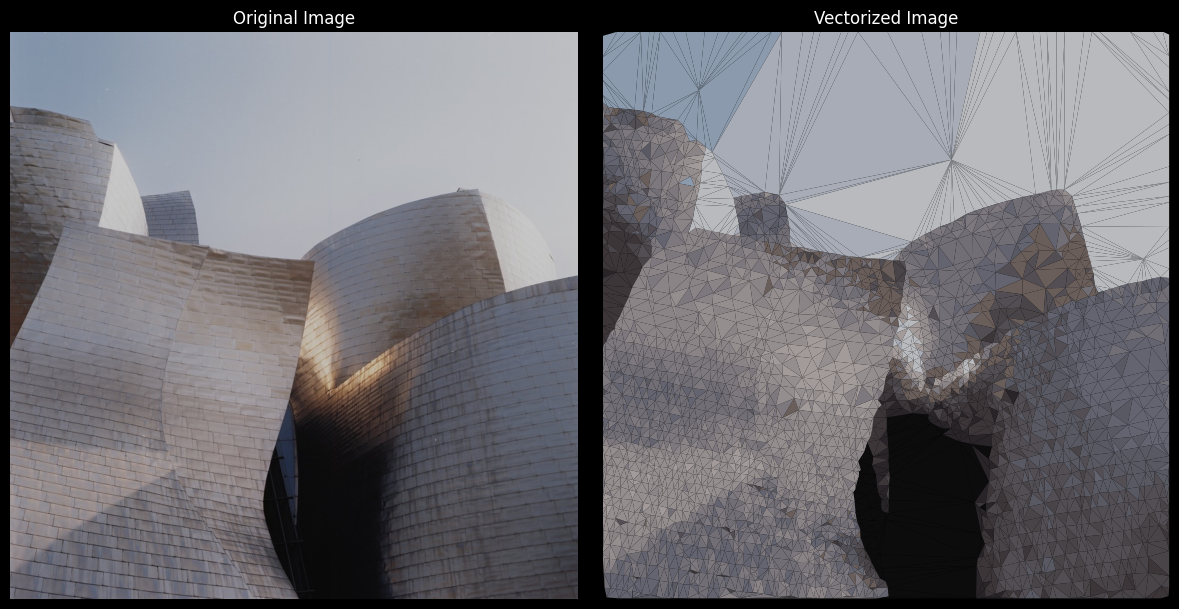

In [7]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Plot vectorized image
plt.subplot(1, 2, 2)
ax = plt.gca()
ax.set_xlim(0, img_array.shape[1])
ax.set_ylim(img_array.shape[0], 0)
ax.set_aspect('equal')
ax.axis('off')

# Create a PolyCollection for the triangles
pc = PolyCollection(verts, facecolors=colors, edgecolors='none')
ax.add_collection(pc)

plt.title('Vectorized Image')
plt.tight_layout()
plt.show()

Optimized vector image saved as 'vectorized_image.svg'


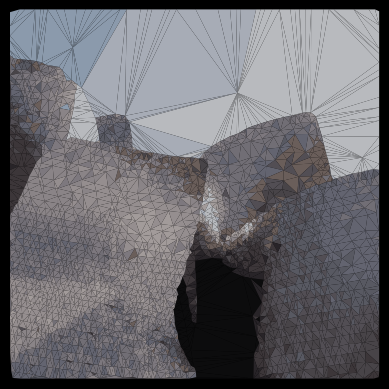

In [8]:
# Plot the vectorized image
fig, ax = plt.subplots()
ax.set_xlim(0, img_array.shape[1])
ax.set_ylim(img_array.shape[0], 0)
ax.set_aspect('equal')
ax.axis('off')

# Create a PolyCollection for the triangles
pc = PolyCollection(verts, facecolors=colors, edgecolors='none')
ax.add_collection(pc)

# Save the vector image to an SVG file with reduced DPI
plt.savefig('data/optimized_vectorized_image.svg', format='svg', bbox_inches='tight', dpi=100)
print("Optimized vector image saved as 'vectorized_image.svg'")